In [1]:
import os
import random
import json
import numpy as np
import pandas as pd
import seaborn as sns
from copy import copy
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import shap

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Users/coimbravieira/Graphviz/bin'

# FUNCTIONS

In [3]:
def set_dim_fig(sizes=(16,20,20)):
    SMALL_SIZE = sizes[0]
    MEDIUM_SIZE = sizes[1]
    BIGGER_SIZE = sizes[2]
    
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [4]:
set_dim_fig()

In [5]:
def plot_cdf(df_stats, cols=[], color=None, xlab="Number of videos watched", ylab="Proportion of users", note=""):
       
    df_stats[cols].plot.hist(figsize=(7,5), cumulative=True, density=1, bins=100, histtype='step', lw=4, alpha=0.6, color=color)

    plt.legend(loc=(0.4,0.05))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.savefig(f"figs/cdf-{xlab}-{note}.pdf", bbox_inches='tight')
    plt.show()

In [6]:
def plot_bar(df_stats, cols=[], color=None, percentage=False, xlab="Number of videos watched", ylab="Proportion of users", k=None, bar="v", stacked=True, figsize=(10,20), note=""):
    
    df_stats = df_stats[cols]
    
    if k:
        df_stats = df_stats[:k]
    
    if bar == "h":
        if len(cols) == 1:
            df_stats.plot.barh(figsize=figsize, stacked=stacked, legend=False)
        else:
            df_stats.plot.barh(figsize=figsize, stacked=stacked)
    else:
        if len(cols) == 1:
            df_stats.plot.bar(figsize=(figsize[1],figsize[0]), stacked=stacked, legend=False)
        else:
            df_stats.plot.bar(figsize=(figsize[1],figsize[0]), stacked=stacked)

    #plt.legend(loc="upper right")
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    if percentage:
        plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 

    ylab = ylab.replace("\n","")
    plt.savefig(f"figs/bar-{ylab}-{note}.pdf", bbox_inches='tight')
    plt.show()

In [7]:
def plot_hist_count_perc (df_all, col='percentage_watched', title='Histogram of the Percentage of Video Watched'):
    # Plot settings
    fig, ax1 = plt.subplots(figsize=(8, 4))
    
    # Plot histogram with counts
    counts, bins, patches = ax1.hist(df_all[col], bins=100, alpha=0.9, color='purple', label=False)
    ax1.set_xlabel('Percentage of the video watched')
    ax1.set_ylabel('Count')
    
    # Create secondary y-axis for percentage
    ax2 = ax1.twinx()
    total = counts.sum()
    percentages = counts / total * 100
    ax2.plot(bins[:-1], percentages, 'w-', linewidth=0.00001, label=False)
    ax2.set_ylabel('Percentage (%)')
    
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"figs/hist_{col}.pdf", bbox_inches='tight')
    plt.show()

In [8]:
def random_model (df_all_rf):
    X2 = df_all_rf["Video ID playlist"]
    y2 = df_all_rf["watched_until_end"]
    
    _, _, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
    
    p0 = y2_train.value_counts(normalize=True)[0]
    p1 = y2_train.value_counts(normalize=True)[1]
    # Generate predictions with the best model
    random.seed(42)
    y2_scores = pd.Series([random.random() for i in y2_test])
    y2_pred = y2_scores.where(y2_scores > p0, 0).where(y2_scores <= p0, 1) 
    
    accuracy2 = accuracy_score(y2_test, y2_pred)
    precision2 = precision_score(y2_test, y2_pred, average="macro")
    recall2 = recall_score(y2_test, y2_pred, average="macro")
    F12 = f1_score(y2_test, y2_pred, average="macro")

    print("Accuracy:", accuracy2)
    print("Precision:", precision2)
    print("Recall:", recall2)
    print("F1:", F12)

    # Compute AUC-ROC
    auc = roc_auc_score(y2_test, y2_scores)
    print(f"AUC-ROC: {auc:.3f}")

    print(f"Random model & {F12:.2f} & {accuracy2:.2f} & {precision2:.2f} & {recall2:.2f} & {auc:.2f} \\\\")
    
    # Create the confusion matrix
    cm2 = confusion_matrix(y2_test, y2_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm2).plot(cmap=plt.cm.Oranges)
    os.makedirs("figs/classification", exist_ok=True)
    plt.savefig("figs/classification/cm-random.pdf", bbox_inches='tight')
    plt.show()

In [9]:
# Helper function to extract prefix from feature name
def get_prefix(name):
    return name.split('_')[0]

def randomforest_tiktok(X2_train, X2_test, y2_train, y2_test, shap_set=None, note=None):
    # --- Save original feature names ---
    feature_names = X2_train.columns

    # --- Save original class names ---
    class_names = {0:"< 100%", 1:"100%"}

    # --- Standardize the Data ---
    sc = StandardScaler()
    X2_train_scaled = sc.fit_transform(X2_train)
    X2_test_scaled = sc.transform(X2_test)

    # --- Re-wrap scaled arrays as DataFrames to preserve column names ---
    X2_train_scaled_df = pd.DataFrame(X2_train_scaled, columns=feature_names)
    X2_test_scaled_df = pd.DataFrame(X2_test_scaled, columns=feature_names)

    print("Train size:", X2_train_scaled_df.shape)
    print("Test size:", X2_test_scaled_df.shape)
    
    # --- Random Search Parameters ---
    param_dist = {
        "max_depth": range(1, 100),
        "min_samples_leaf": range(2, 20),
        "n_estimators": range(10, 100, 10)
    }

    rf = RandomForestClassifier(class_weight = "balanced", random_state=42)

    rand_search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        random_state=42,
        refit=True
    )

    # --- Fit Model ---
    rand_search.fit(X2_train_scaled_df, y2_train)
    y2_pred = rand_search.predict(X2_test_scaled_df)

    # --- Evaluation ---
    cm = confusion_matrix(y2_test, y2_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Oranges)
    os.makedirs("figs/classification", exist_ok=True)
    plt.savefig(f"figs/classification/cm-{note}.pdf", bbox_inches='tight')
    plt.show()

    accuracy = accuracy_score(y2_test, y2_pred)
    precision = precision_score(y2_test, y2_pred, average="macro")
    recall = recall_score(y2_test, y2_pred, average="macro")
    f1 = f1_score(y2_test, y2_pred, average="macro")

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

    # Compute AUC-ROC
    y2_scores = rand_search.predict_proba(X2_test_scaled_df)[:, 1]
    auc = roc_auc_score(y2_test, y2_scores)
    print(f"AUC-ROC: {auc:.3f}")

    print(f"{note} & {f1:.2f} & {accuracy:.2f} & {precision:.2f} & {recall:.2f} & {auc:.2f} \\\\")
    
    # Compute ROC curve points
    fpr, tpr, thresholds = roc_curve(y2_test, y2_scores)
    
    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Tune threshold to maximize F1 score
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.linspace(0, 1, 101):
        y_pred_thresh = (y2_scores >= thresh).astype(int)
        f1 = f1_score(y2_test, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    print(f"Best F1: {best_f1:.3f} at threshold {best_thresh:.2f}")
    # Final prediction using best threshold
    y2_pred_final = (y2_scores >= best_thresh).astype(int)


    # --- Feature Importances ---
    best_rf = rand_search.best_estimator_
    feature_importances = pd.Series(best_rf.feature_importances_, index=feature_names)

    grouped_importances_sum = feature_importances.groupby(get_prefix).sum()
    grouped_importances_max = feature_importances.groupby(get_prefix).max()
    grouped_importances_median = feature_importances.groupby(get_prefix).median()

    if (note == "model_all") or (note == "model_dem"):
        feature_importances.sort_values(ascending=False).head(50).plot.bar(figsize=(15, 5))
        plt.savefig(f"figs/classification/fi-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_sum.sort_values(ascending=False).plot.bar(figsize=(15, 5), title="Grouped Feature Importances (sum)")
        plt.savefig(f"figs/classification/fi-grouped-sum-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_max.sort_values(ascending=False).plot.bar(figsize=(15, 5), title="Grouped Feature Importances (max)")
        plt.savefig(f"figs/classification/fi-grouped-max-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_median.sort_values(ascending=False).plot.bar(figsize=(15, 5), title="Grouped Feature Importances (median)")
        plt.savefig(f"figs/classification/fi-grouped-median-{note}.pdf", bbox_inches='tight')
        plt.show()
    
    else:
        feature_importances.sort_values(ascending=True).tail(10).plot.barh(figsize=(5, 5))
        plt.savefig(f"figs/classification/fi-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_sum.sort_values(ascending=True).plot.barh(figsize=(5, 5), title="Grouped Feature Importances (sum)")
        plt.savefig(f"figs/classification/fi-grouped-sum-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_max.sort_values(ascending=True).plot.barh(figsize=(5, 5), title="Grouped Feature Importances (max)")
        plt.savefig(f"figs/classification/fi-grouped-max-{note}.pdf", bbox_inches='tight')
        plt.show()
        grouped_importances_median.sort_values(ascending=True).plot.barh(figsize=(5, 5), title="Grouped Feature Importances (median)")
        plt.savefig(f"figs/classification/fi-grouped-median-{note}.pdf", bbox_inches='tight')
        plt.show()

    if shap_set == "test":
        X2_train_or_test_scaled_df = X2_test_scaled_df
        note = "testset-" + note

    elif shap_set == "train":
        X2_train_or_test_scaled_df = X2_train_scaled_df
        note = "trainset-" + note

    else:
        return rand_search

    # --- SHAP Analysis with new API and beeswarm plots ---
    explainer = shap.TreeExplainer(best_rf)
    shap_values = np.array(explainer.shap_values(X2_train_or_test_scaled_df))
    #print(shap_values.shape) # This returns a shap.Explanation object

    #shap_values_class_0 = shap_values[:, :, 0]  # SHAP values for class 0
    #shap_values_class_1 = shap_values[:, :, 1]  # SHAP values for class 1
    #shap_values_class_2 = shap_values[:, :, 2]  # SHAP values for class 2

    # If multiclass: shap_values[i] contains class-specific contributions
    for i in range(shap_values.shape[2]):  # Loop over number of classes
        print(f"Generating SHAP beeswarm plot for class {i}")
        plt.figure()
        shap.summary_plot(shap_values[:, :, i], X2_train_or_test_scaled_df, show=False)
        plt.title("Class " + str(i) + ":\nUsers who watched " + class_names[i] + " of the video duration")
        plt.savefig(f"figs/classification/shap-{note}-class-{i}.pdf", bbox_inches='tight')
        plt.show()

    return rand_search

## Dataset

In [10]:
df_all = pd.read_csv("data/data_survey&trace&interests_dummy.csv", index_col=0)
df_all

,Date,Link,video_id,in_playlist,in_playlist_final,video_id_playlist,video_id_playlist_final,watching_time,video_duration,video_likes,...,When access TikTok_When getting up in the morning,When access TikTok_When nothing to do,When access TikTok_When traveling,When access TikTok_When using the restroom,When access TikTok_When waiting shortly,common_interests,all_interests,jacc_original_interests,num_topics_video,jacc_interests
0,2023-09-19 12:33:07,https://www.tiktokv.com/share/video/7270933407...,7270933407155277102,1,1,0,0,26.0,24.0,1500000.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
1,2023-09-19 12:33:33,https://www.tiktokv.com/share/video/7266282716...,7266282716625161474,1,1,1,1,3.0,9.0,49100.0,...,0,1,1,1,1,1.0,33.0,0.030303,1.0,1.00
2,2023-09-19 12:33:41,https://www.tiktokv.com/share/video/7256194262...,7256194262050802990,1,1,2,2,15.0,470.0,3373.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
3,2023-09-19 12:33:56,https://www.tiktokv.com/share/video/7255321132...,7255321132495047979,1,1,3,3,114.0,331.0,2900000.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
4,2023-09-19 12:35:50,https://www.tiktokv.com/share/video/7271266223...,7271266223709572354,1,1,6,4,13.0,16.0,378700.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130,2023-09-22 16:48:35,https://www.tiktokv.com/share/video/7267772520...,7267772520500186410,1,1,20,18,13.0,12.0,2500000.0,...,1,1,1,1,1,1.0,7.0,0.142857,2.0,0.50
5131,2023-09-22 16:48:48,https://www.tiktokv.com/share/video/7275683226...,7275683226792807682,1,1,21,19,10.0,8.0,151400.0,...,1,1,1,1,1,1.0,9.0,0.111111,4.0,0.25
5132,2023-09-22 16:48:58,https://www.tiktokv.com/share/video/7247911468...,7247911468098751770,1,1,22,20,27.0,25.0,1300000.0,...,1,1,1,1,1,1.0,7.0,0.142857,2.0,0.50
5133,2023-09-22 16:49:25,https://www.tiktokv.com/share/video/7249404952...,7249404952727031066,1,1,23,21,10.0,7.0,441200.0,...,1,1,1,1,1,0.0,8.0,0.000000,2.0,0.00


# EXPLORATORY ANALYSIS

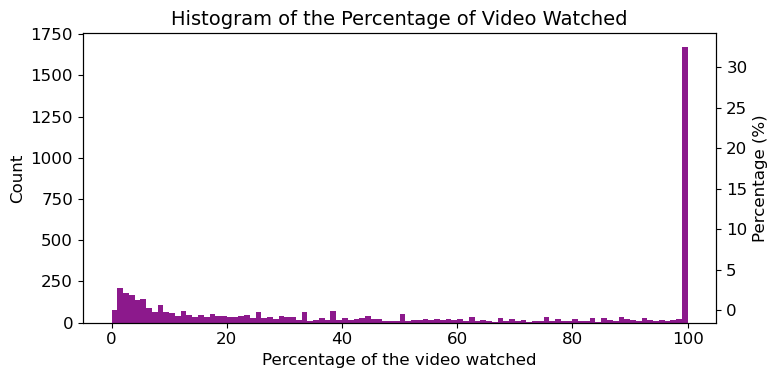

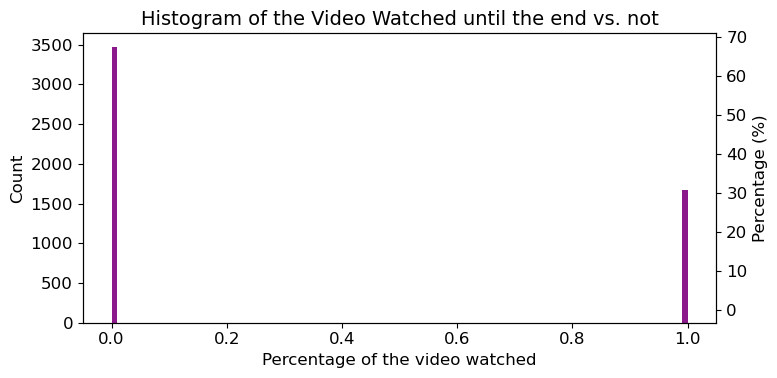

In [11]:
set_dim_fig((12,14,14))
plot_hist_count_perc (df_all, col='percentage_watched', title='Histogram of the Percentage of Video Watched')
plot_hist_count_perc (df_all, col='watched_until_end', title='Histogram of the Video Watched until the end vs. not')
set_dim_fig()

In [12]:
df_all

,Date,Link,video_id,in_playlist,in_playlist_final,video_id_playlist,video_id_playlist_final,watching_time,video_duration,video_likes,...,When access TikTok_When getting up in the morning,When access TikTok_When nothing to do,When access TikTok_When traveling,When access TikTok_When using the restroom,When access TikTok_When waiting shortly,common_interests,all_interests,jacc_original_interests,num_topics_video,jacc_interests
0,2023-09-19 12:33:07,https://www.tiktokv.com/share/video/7270933407...,7270933407155277102,1,1,0,0,26.0,24.0,1500000.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
1,2023-09-19 12:33:33,https://www.tiktokv.com/share/video/7266282716...,7266282716625161474,1,1,1,1,3.0,9.0,49100.0,...,0,1,1,1,1,1.0,33.0,0.030303,1.0,1.00
2,2023-09-19 12:33:41,https://www.tiktokv.com/share/video/7256194262...,7256194262050802990,1,1,2,2,15.0,470.0,3373.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
3,2023-09-19 12:33:56,https://www.tiktokv.com/share/video/7255321132...,7255321132495047979,1,1,3,3,114.0,331.0,2900000.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
4,2023-09-19 12:35:50,https://www.tiktokv.com/share/video/7271266223...,7271266223709572354,1,1,6,4,13.0,16.0,378700.0,...,0,1,1,1,1,2.0,33.0,0.060606,2.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130,2023-09-22 16:48:35,https://www.tiktokv.com/share/video/7267772520...,7267772520500186410,1,1,20,18,13.0,12.0,2500000.0,...,1,1,1,1,1,1.0,7.0,0.142857,2.0,0.50
5131,2023-09-22 16:48:48,https://www.tiktokv.com/share/video/7275683226...,7275683226792807682,1,1,21,19,10.0,8.0,151400.0,...,1,1,1,1,1,1.0,9.0,0.111111,4.0,0.25
5132,2023-09-22 16:48:58,https://www.tiktokv.com/share/video/7247911468...,7247911468098751770,1,1,22,20,27.0,25.0,1300000.0,...,1,1,1,1,1,1.0,7.0,0.142857,2.0,0.50
5133,2023-09-22 16:49:25,https://www.tiktokv.com/share/video/7249404952...,7249404952727031066,1,1,23,21,10.0,7.0,441200.0,...,1,1,1,1,1,0.0,8.0,0.000000,2.0,0.00


In [13]:
df_p_watch = pd.DataFrame(df_all[["watched_until_end", "tt_account"]].groupby("tt_account").sum())
df_p_watch["watched"] = pd.DataFrame(df_all[["watched_until_end", "tt_account"]].groupby("tt_account").count())
df_p_watch.describe()

,watched_until_end,watched
count,80.000000,80.000000
mean,20.837500,64.187500
std,5.928784,28.716904
min,7.000000,13.000000
25%,16.750000,43.000000
50%,21.000000,59.000000
75%,25.000000,94.500000
max,33.000000,105.000000


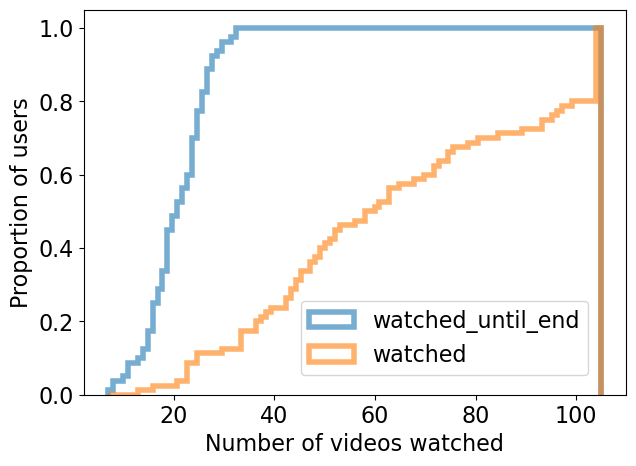

In [14]:
plot_cdf(df_p_watch, cols=["watched_until_end", "watched"], color=None, 
         xlab="Number of videos watched", ylab="Proportion of users", 
         note="playlist-final")

In [15]:
df_v_watch = pd.DataFrame(df_all[["watched_until_end", "video_id_playlist_final"]].groupby("video_id_playlist_final").sum())
df_v_watch["watched"] = pd.DataFrame(df_all[["watched_until_end", "video_id_playlist_final"]].groupby("video_id_playlist_final").count())
df_v_watch.describe()

,watched_until_end,watched
count,105.000000,105.000000
mean,15.876190,48.904762
std,17.464081,23.103248
min,0.000000,16.000000
25%,1.000000,26.000000
50%,8.000000,46.000000
75%,25.000000,71.000000
max,64.000000,80.000000


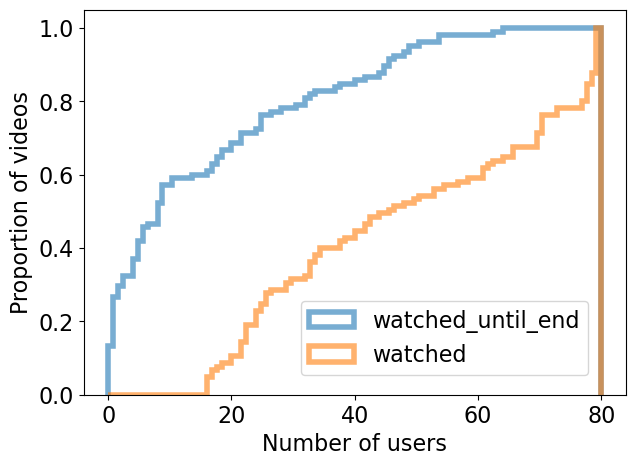

In [16]:
plot_cdf(df_v_watch, cols=["watched_until_end", "watched"], color=None, 
         xlab="Number of users", ylab="Proportion of videos", 
         note="playlist-final")

In [17]:
df_v = df_all[["video_id_playlist_final", "video_duration"]].drop_duplicates().set_index("video_id_playlist_final")
df_v.index.name = None
df_v

,video_duration
0,24.0
1,9.0
2,470.0
3,331.0
4,16.0
...,...
100,87.0
101,69.0
102,81.0
103,10.0


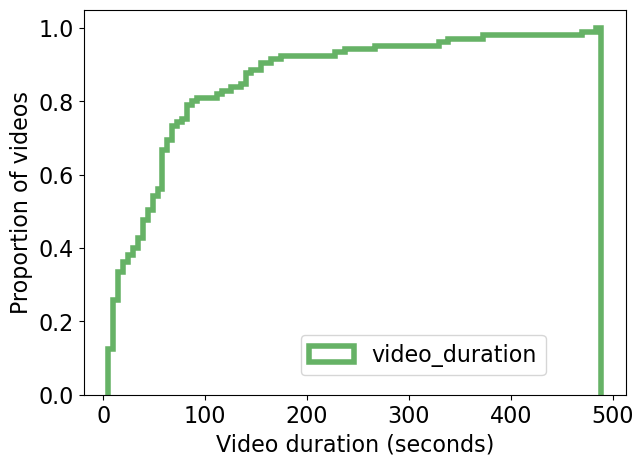

In [18]:
plot_cdf(df_v, cols=["video_duration"], color="green",
         xlab="Video duration (seconds)", ylab="Proportion of videos", 
         note="playlist-final")

In [19]:
df_v = df_v.merge(df_v_watch, left_index=True, right_index=True) #getting the number of participants who watched & until the end each video
df_v["%watched_until_end"] = df_v_watch["watched_until_end"] / df_v_watch["watched"] * 100
df_v

,video_duration,watched_until_end,watched,%watched_until_end
0,24.0,49,80,61.25
1,9.0,45,80,56.25
2,470.0,4,80,5.00
3,331.0,8,80,10.00
4,16.0,40,80,50.00
...,...,...,...,...
100,87.0,0,16,0.00
101,69.0,0,16,0.00
102,81.0,1,16,6.25
103,10.0,6,16,37.50


C:\Users\coimbravieira\AppData\Local\Temp\ipykernel_13088\3232190864.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()])


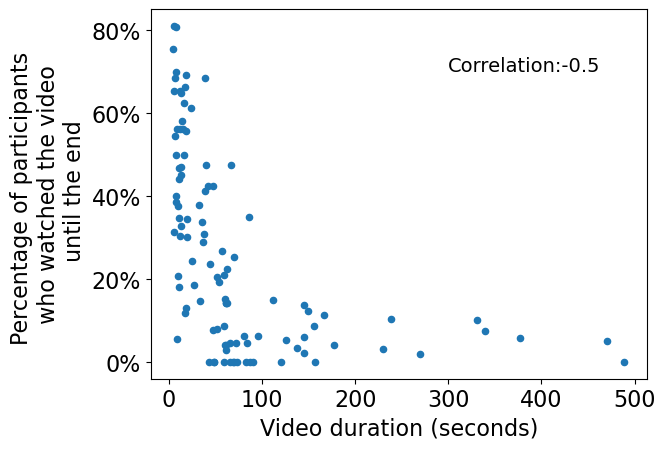

In [20]:
df_v.plot.scatter("video_duration", "%watched_until_end") #percentage of users who watched the video until the end
#plt.title("Correlation between video duration \nand the percentage of participants who \nwatched the video until the end: " + str(round(df_v_watch["video_duration"].corr(df_v_watch["%watched_until_end"]), 2)))
plt.xlabel("Video duration (seconds)")
plt.ylabel("Percentage of participants \n who watched the video \n until the end")
plt.text(300, 70, "Correlation:" + str(round(df_v["video_duration"].corr(df_v["%watched_until_end"]), 2)), size=14)
plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
plt.savefig(f"figs/scatter-video-duration-perc_watched.pdf", bbox_inches='tight')
plt.show()

C:\Users\coimbravieira\AppData\Local\Temp\ipykernel_13088\358812096.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()])


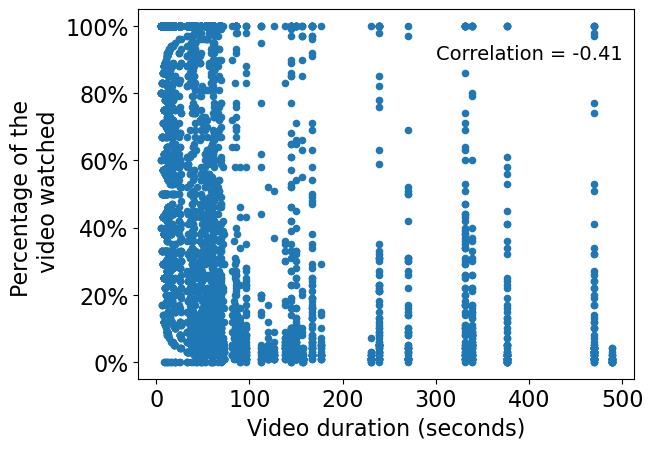

In [21]:
df_all.plot.scatter("video_duration", "percentage_watched") #percentage of the video watched
plt.xlabel("Video duration (seconds)")
plt.ylabel("Percentage of the \n video watched")
plt.text(300, 90, "Correlation = " + str(round(df_all["video_duration"].corr(df_all["percentage_watched"]), 2)), size=14)
plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
plt.savefig(f"figs/scatter-video-duration-perc_watched-video.pdf", bbox_inches='tight')
plt.show()

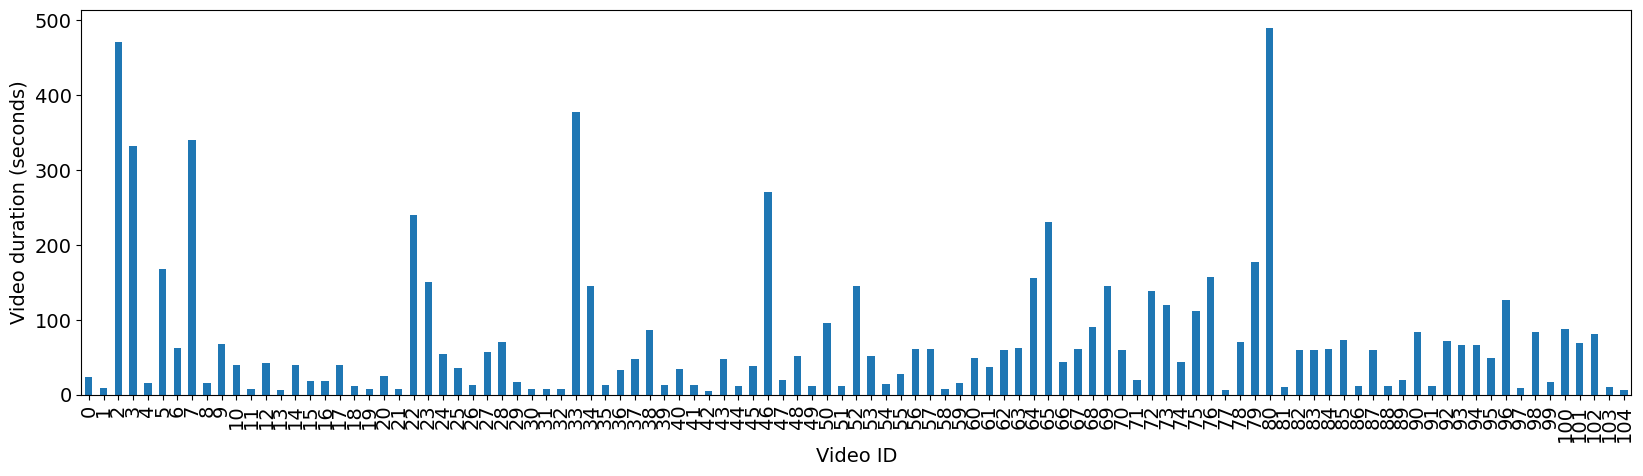

In [22]:
set_dim_fig((14,20,20))
plot_bar(df_stats=df_v, cols=["video_duration"], bar="v",
         xlab="Video ID", ylab="Video duration (seconds)", note="order", figsize=(5,20))
set_dim_fig()

C:\Users\coimbravieira\AppData\Local\Temp\ipykernel_13088\1407657784.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()])


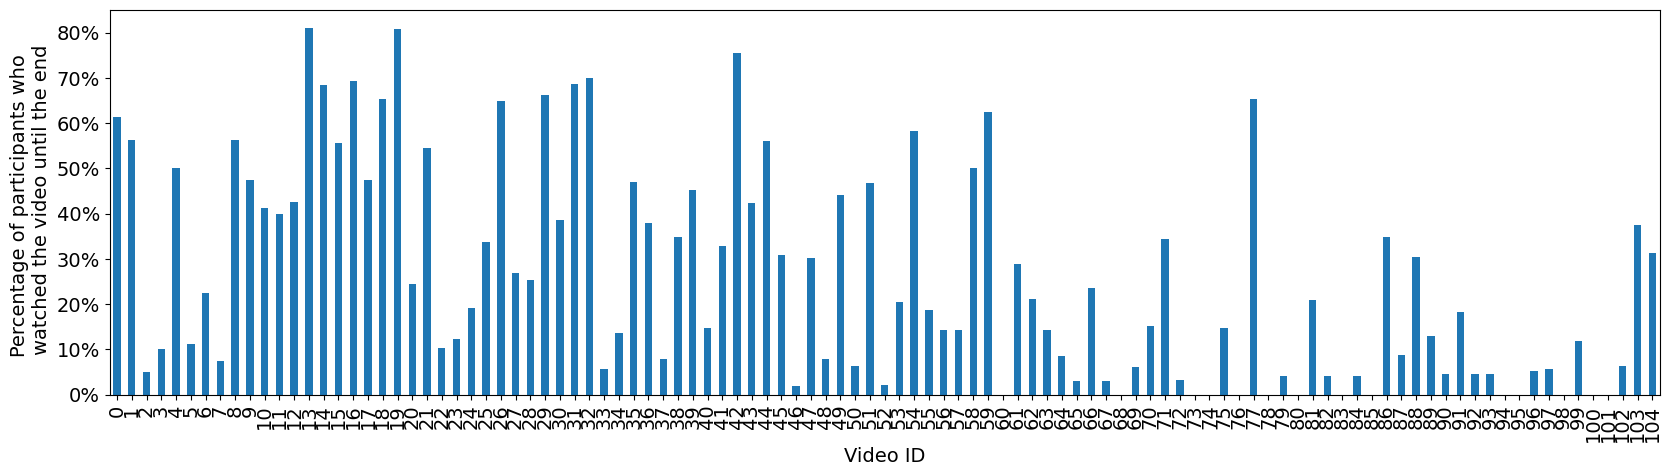

In [23]:
set_dim_fig((14,20,20))
plot_bar(df_stats=df_v, cols=["%watched_until_end"], bar="v", percentage=True,
         xlab="Video ID", ylab="Percentage of participants who \n watched the video until the end", note="order", figsize=(5,20))
set_dim_fig()

In [24]:
df_all[["SEQUENTIAL_ID", "tt_account"]].drop_duplicates().sort_values(by="SEQUENTIAL_ID")

,SEQUENTIAL_ID,tt_account
1461,48,tt_account18
2464,53,tt_account43-2109
2821,84,tt_account51
3108,95,tt_account63
3864,115,tt_account77
...,...,...
489,907,tt_account110
4888,925,tt_account94
741,934,tt_account116
1162,954,tt_account134


In [25]:
df_heatmap_aux = df_all[["video_id_playlist_final", "tt_account", "percentage_watched"]]
df_heatmap = pd.pivot_table(df_heatmap_aux, values="percentage_watched", index="tt_account",
                       columns="video_id_playlist_final")
df_heatmap.fillna(-1, inplace=True)
df_heatmap

video_id_playlist_final,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
tt_account,,,,,,,,,,,,,,,,,,,,,
tt_account1,100.0,33.0,3.0,34.0,81.0,13.0,6.0,2.0,27.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account10,46.0,22.0,12.0,30.0,38.0,2.0,100.0,1.0,100.0,49.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account101,100.0,100.0,10.0,43.0,100.0,14.0,63.0,5.0,73.0,36.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account102,67.0,67.0,5.0,100.0,100.0,2.0,39.0,100.0,33.0,69.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account107,29.0,78.0,1.0,100.0,100.0,19.0,16.0,1.0,13.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt_account94,100.0,100.0,4.0,4.0,100.0,15.0,87.0,30.0,80.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account95,100.0,100.0,74.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
tt_account96,100.0,100.0,24.0,26.0,100.0,25.0,76.0,5.0,100.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [26]:
df_heatmap.reset_index(inplace=True, drop=True)
# reset the index and add 1 to each value
df_heatmap.index = df_heatmap.index + 1
df_heatmap

video_id_playlist_final,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
1,100.0,33.0,3.0,34.0,81.0,13.0,6.0,2.0,27.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,46.0,22.0,12.0,30.0,38.0,2.0,100.0,1.0,100.0,49.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,100.0,100.0,10.0,43.0,100.0,14.0,63.0,5.0,73.0,36.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,67.0,67.0,5.0,100.0,100.0,2.0,39.0,100.0,33.0,69.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,29.0,78.0,1.0,100.0,100.0,19.0,16.0,1.0,13.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,100.0,100.0,4.0,4.0,100.0,15.0,87.0,30.0,80.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
77,100.0,100.0,74.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
78,100.0,100.0,24.0,26.0,100.0,25.0,76.0,5.0,100.0,100.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
79,33.0,67.0,1.0,3.0,44.0,4.0,48.0,5.0,40.0,24.0,...,27.0,100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


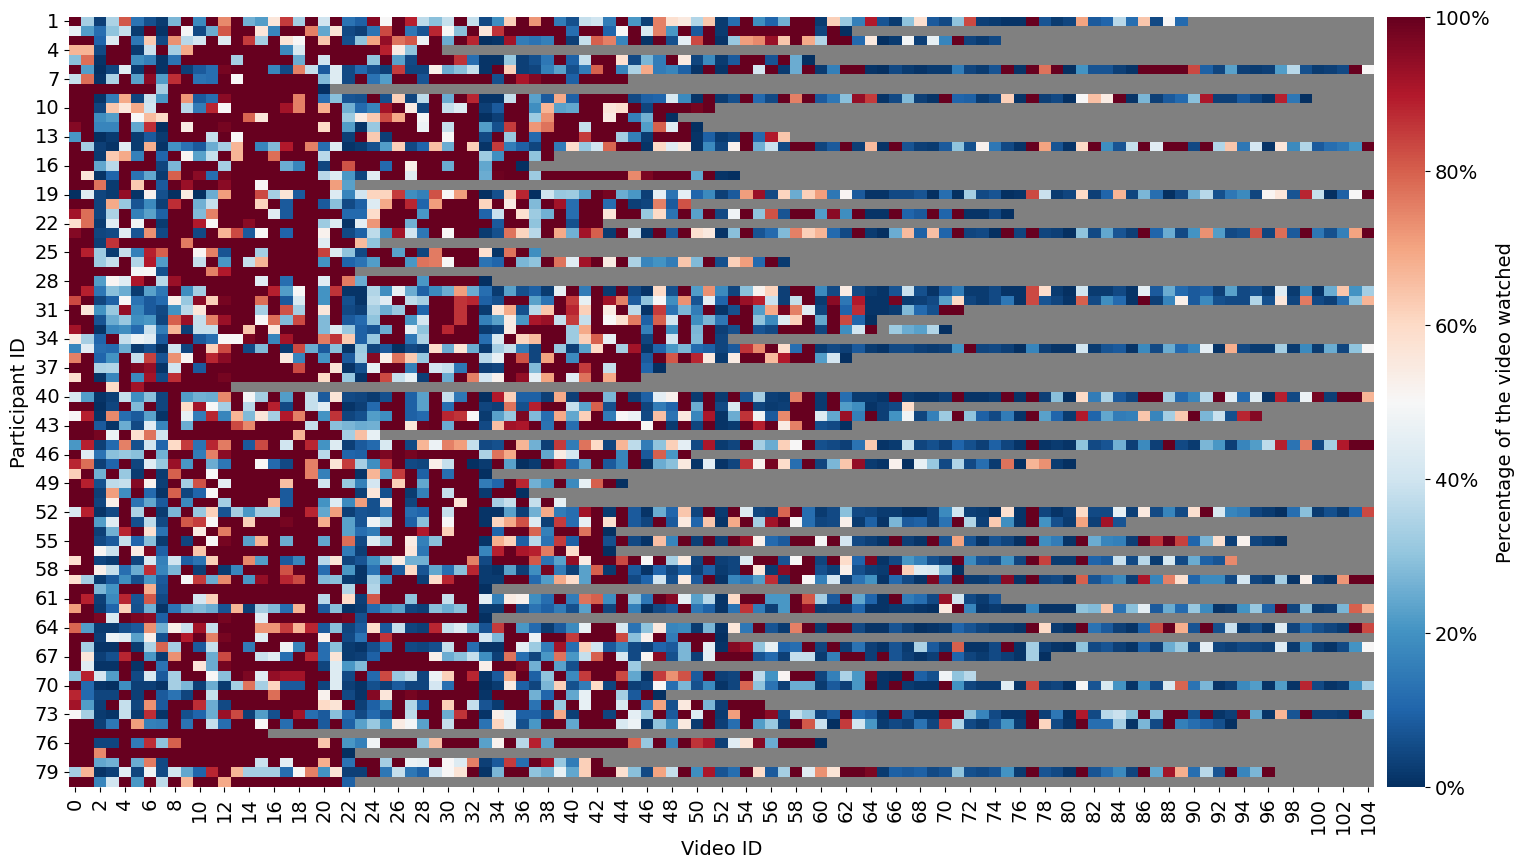

In [27]:
set_dim_fig((14,20,20))

my_cmap = copy(plt.cm.RdBu_r)
my_cmap.set_under("gray")

fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(
    df_heatmap, 
    cmap=my_cmap, 
    vmin=0, 
    vmax=100, 
    ax=ax,
    cbar_kws=dict(
        label='Percentage of the video watched',
        use_gridspec=False,
        location="right",
        pad=0.008
    )
)
plt.xlabel("Video ID")
plt.yticks(rotation=0)
plt.ylabel("Participant ID")

# Format colorbar ticks as percentages
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

# Manually adjust colorbar width only
#pos = cbar.ax.get_position()
#cbar.ax.set_position([pos.x0, pos.y0, 0.01, pos.height])  # Width only

plt.savefig(f"figs/heatmap.pdf", bbox_inches="tight")
plt.show()
set_dim_fig()

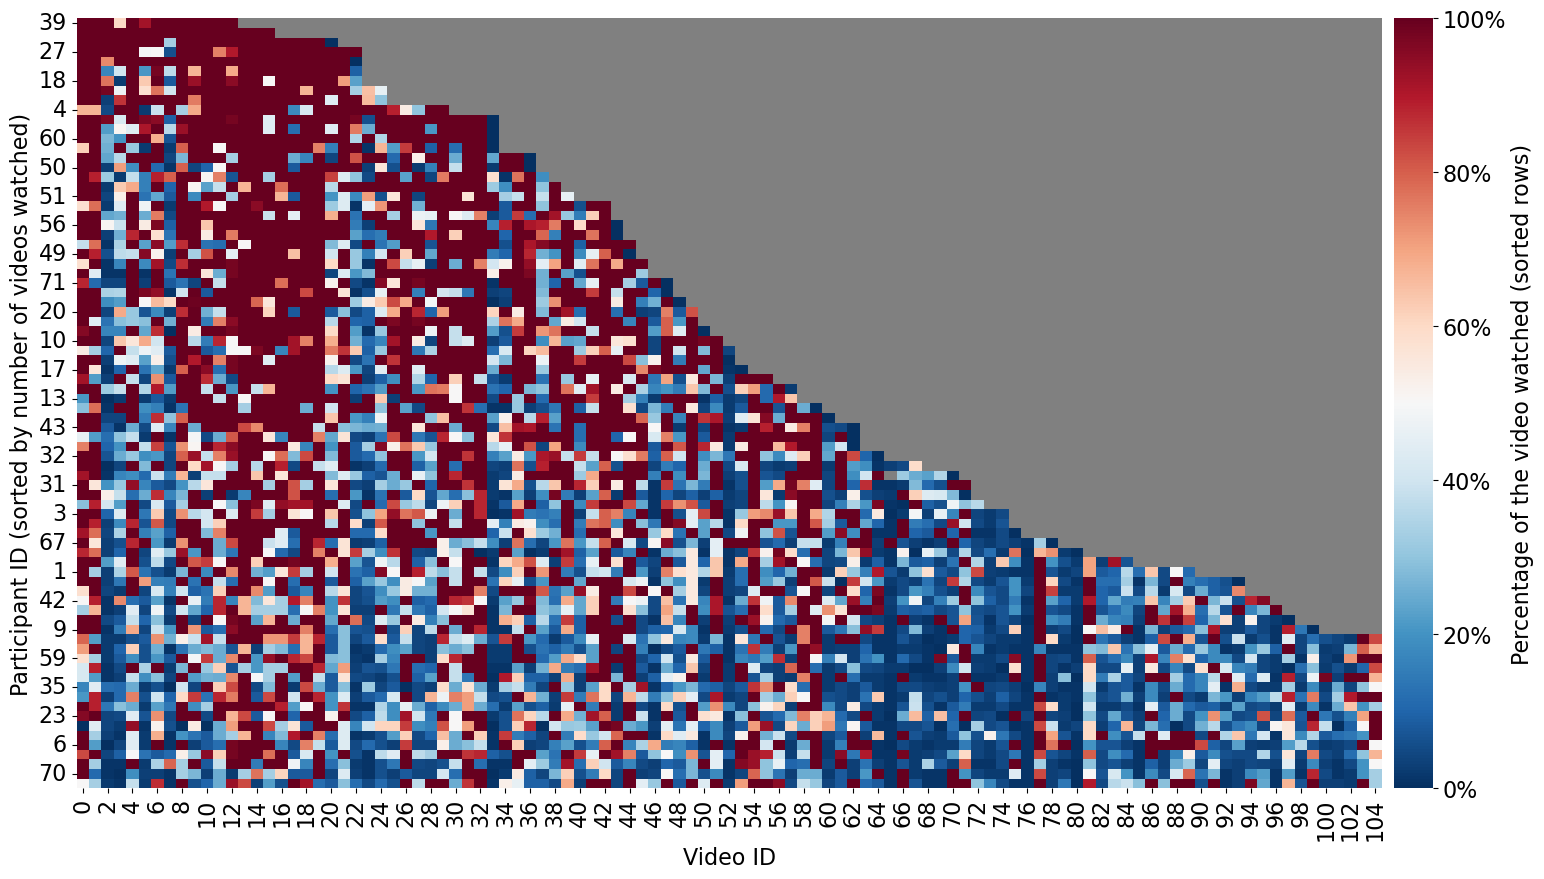

In [28]:
# Second heatmap: rows sorted by non-negative cell counts
# Count non-negative values (>= 0) in each row and sort
df_sorted = df_heatmap.loc[(df_heatmap >= 0).sum(axis=1).sort_values(ascending=True).index]

fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(
    df_sorted,
    cmap=my_cmap,
    vmin=0,
    vmax=100,
    ax=ax,
    cbar_kws=dict(
        label='Percentage of the video watched (sorted rows)',
        use_gridspec=False,
        location="right",
        pad=0.008
    )
)
plt.xlabel("Video ID")
plt.yticks(rotation=0)
plt.ylabel("Participant ID (sorted by number of videos watched)")

# Format colorbar ticks as percentages
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig("figs/heatmap_sorted.pdf", bbox_inches="tight")
plt.show()

set_dim_fig()

## Comparison with TikTok statistics

In [29]:
df_tiktok_stats = pd.read_csv("data/Prolific_groups.csv")
df_tiktok_stats

,Age,%Female,%Male
0,18-24,20.9,17.5
1,25-34,17.0,15.5
2,35-44,8.1,7.5
3,45-54,4.3,3.7
4,55+,3.1,2.4
5,18+,53.4,46.6


In [30]:
df_prolific_groups = df_all[["prolific_group", "tt_account"]].drop_duplicates().groupby(by="prolific_group").count()
df_prolific_groups["Participants"] = df_prolific_groups["tt_account"]/df_prolific_groups["tt_account"].sum()*100
df_prolific_groups

,tt_account,Participants
prolific_group,,
"FEMALE, 18-24",17,21.25
"FEMALE, 25-34",18,22.50
"FEMALE, 35-44",6,7.50
"FEMALE, 45-54",2,2.50
"FEMALE, 55+",3,3.75
"MALE, 18-24",16,20.00
"MALE, 25-34",9,11.25
"MALE, 35-44",4,5.00
"MALE, 45-54",4,5.00


In [31]:
stats_tt = list(df_tiktok_stats["%Female"][:5]) + list(df_tiktok_stats["%Male"][:5])
df_prolific_groups["TikTok statistics 2023"] = stats_tt
df_prolific_groups

,tt_account,Participants,TikTok statistics 2023
prolific_group,,,
"FEMALE, 18-24",17,21.25,20.9
"FEMALE, 25-34",18,22.50,17.0
"FEMALE, 35-44",6,7.50,8.1
"FEMALE, 45-54",2,2.50,4.3
"FEMALE, 55+",3,3.75,3.1
"MALE, 18-24",16,20.00,17.5
"MALE, 25-34",9,11.25,15.5
"MALE, 35-44",4,5.00,7.5
"MALE, 45-54",4,5.00,3.7


Total participants:  80


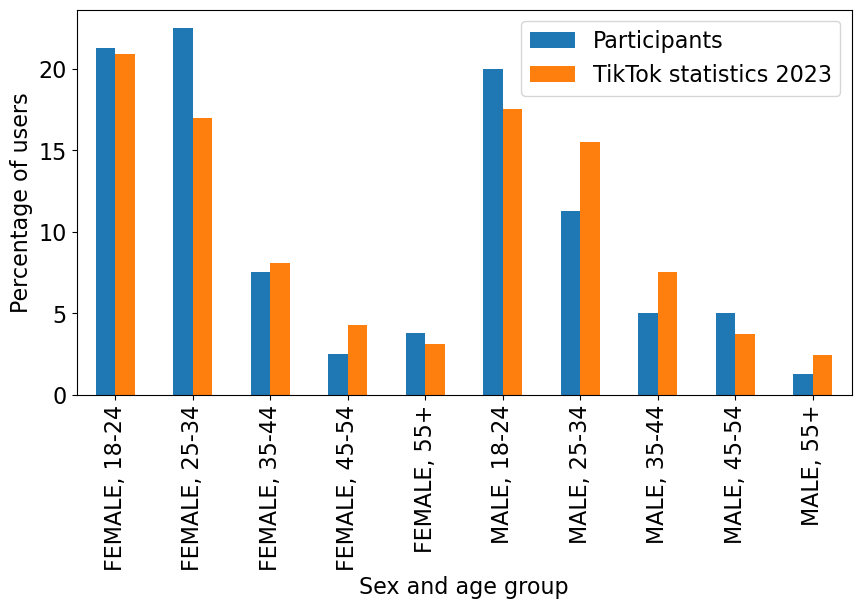

In [32]:
print("Total participants: ", df_prolific_groups["tt_account"].sum())
plot_bar(df_stats=df_prolific_groups, cols=["Participants","TikTok statistics 2023"], bar="v", stacked=False, 
         xlab="Sex and age group", ylab="Percentage of users", figsize=(5,10))

# CLASSIFICATION

# TikTok Experiment data

## Feature selection

In [33]:
# One-hot encode the SEQUENTIAL_ID column
one_hot_user_df = pd.get_dummies(df_all['SEQUENTIAL_ID'], prefix='User ID')

df_all_rf = df_all.drop(columns=['Date', 'Link','video_id','in_playlist','in_playlist_final','video_id_playlist', 'watching_time',
                                 'percentage_watched_float','percentage_watched', 'prolific_group','SEQUENTIAL_ID',
                                 'tt_account','like','comment', 'common_interests','all_interests', 'num_topics_video', 
                                 'jacc_original_interests', 'video_saves', 'watched_6s+'])

df_all_rf.rename(columns={"jacc_interests": "Interest Similarity", 
                         'video_id_playlist_final': "Video ID playlist",
                         'video_duration': "Video duration",
                         'video_likes': "Video num. likes",
                         'video_shares': "Video num. shares",
                         'video_comments': "Video num. comments",
                         'video_plays': "Video num. plays"}, inplace=True)

df_all_rf = df_all_rf.merge(one_hot_user_df, left_index=True, right_index=True) # adding one hot encoding user ID"

## Random model

Accuracy: 0.5511197663096398
Precision: 0.49291442592956747
Recall: 0.49288266160544825
F1: 0.4928938278216629
AUC-ROC: 0.489
Random model & 0.49 & 0.55 & 0.49 & 0.49 & 0.49 \\


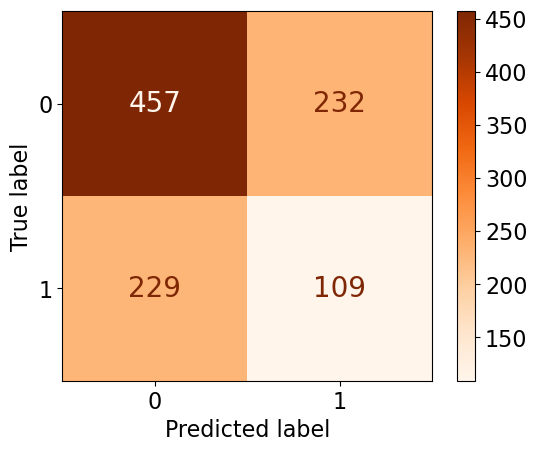

In [34]:
random_model(df_all_rf)

## Model all features

In [35]:
columns_rf = [c for c in df_all_rf.columns.tolist() if c != 'watched_until_end']

In [36]:
X2_all = df_all_rf[columns_rf]
y2_all = df_all_rf["watched_until_end"]

In [37]:
# Split the data into training and test sets
X2_train_all, X2_test_all, y2_train_all, y2_test_all = train_test_split(X2_all, y2_all, test_size=0.2, random_state=42)

Train size: (4108, 166)
Test size: (1027, 166)


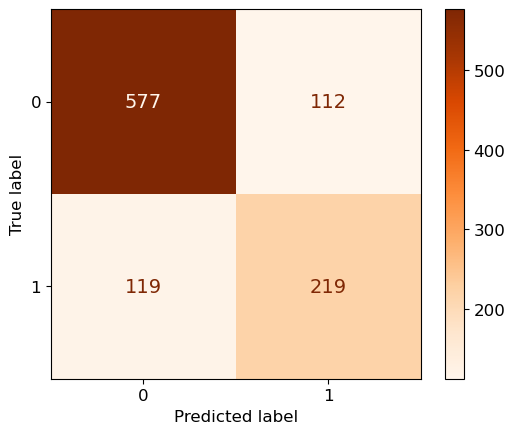

Accuracy: 0.7750730282375852
Precision: 0.7453272042226621
Recall: 0.742687283688735
F1: 0.7439607582846319
AUC-ROC: 0.832
model_all & 0.74 & 0.78 & 0.75 & 0.74 & 0.83 \\


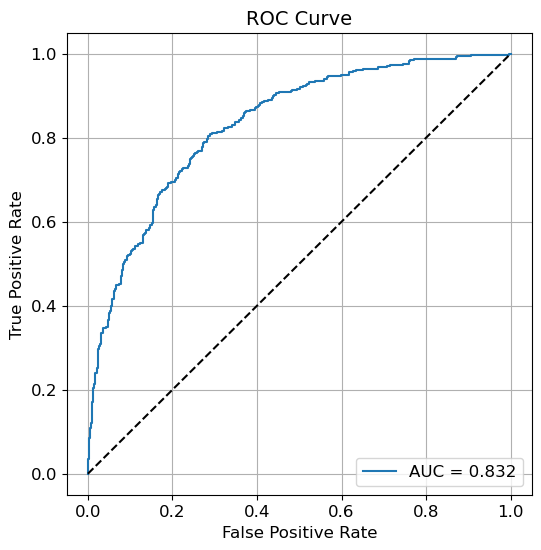

Best F1: 0.673 at threshold 0.38


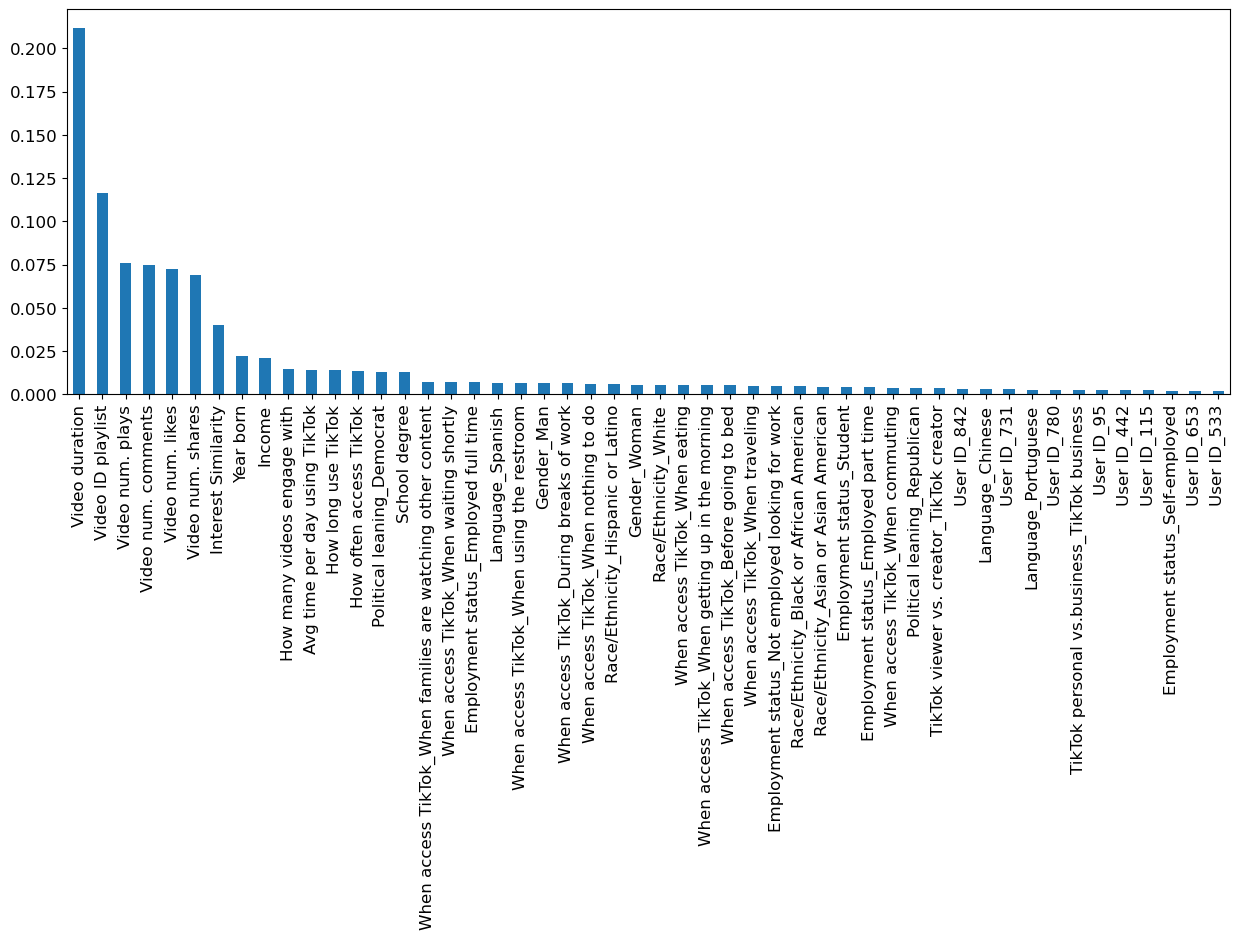

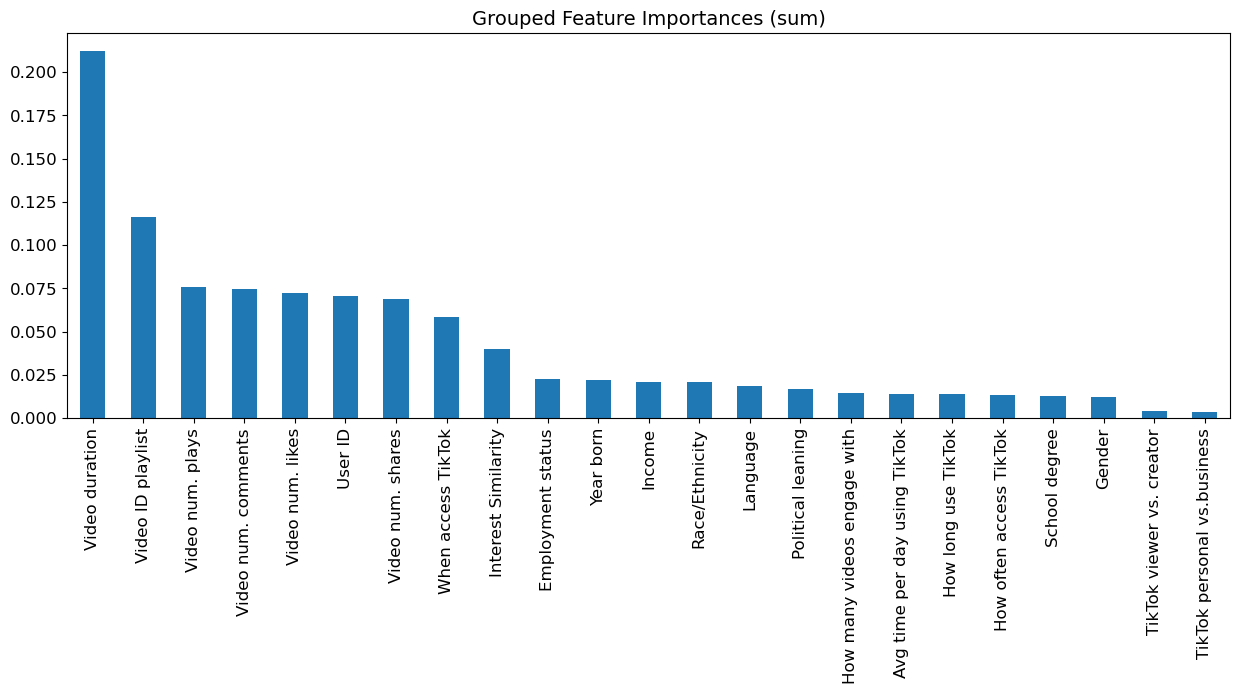

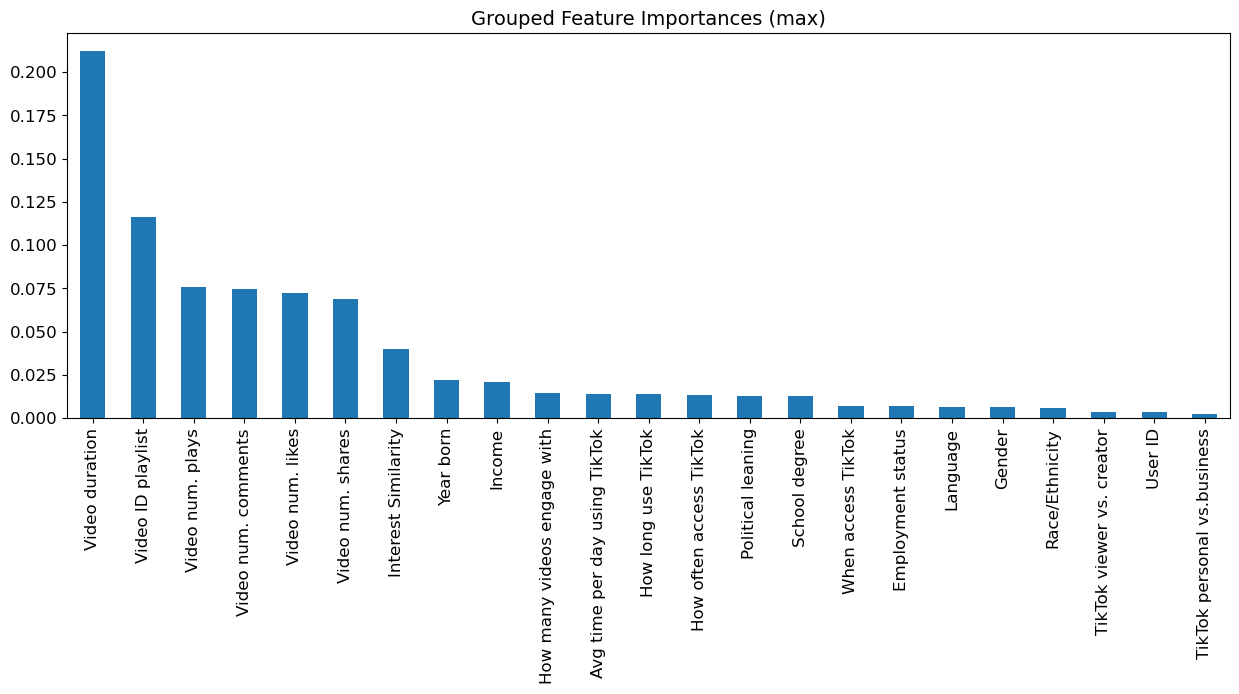

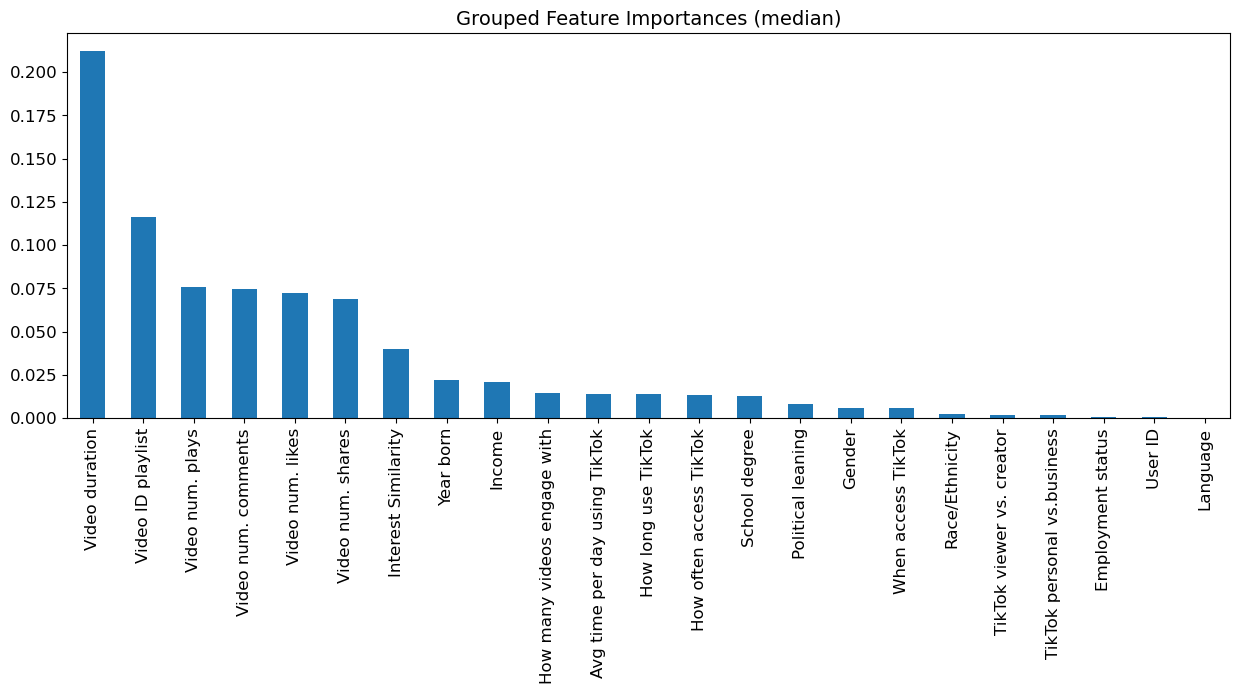

In [38]:
set_dim_fig((12,14,20))
rand_search_all = randomforest_tiktok(X2_train_all, X2_test_all, y2_train_all, y2_test_all, note="model_all")
#rand_search_all = randomforest_tiktok(X2_train_all, X2_test_all, y2_train_all, y2_test_all, shap_set="train", note="model_all")
#rand_search_all = randomforest_tiktok(X2_train_all, X2_test_all, y2_train_all, y2_test_all, shap_set="test", note="model_all")

## Model video metadata

In [39]:
columns_meta = ["Video duration", 
                "Video ID playlist", 
                "Video num. plays", 
                "Video num. comments", 
                "Video num. shares", 
                "Video num. likes"]

In [40]:
X2_meta = df_all_rf[columns_meta + [c for c in columns_rf if  "User ID"==c.split("_")[0]]]
y2_meta = df_all_rf["watched_until_end"]

In [41]:
# Split the data into training and test sets
X2_train_meta, X2_test_meta, y2_train_meta, y2_test_meta = train_test_split(X2_meta, y2_meta, test_size=0.2, random_state=42)

Train size: (4108, 86)
Test size: (1027, 86)


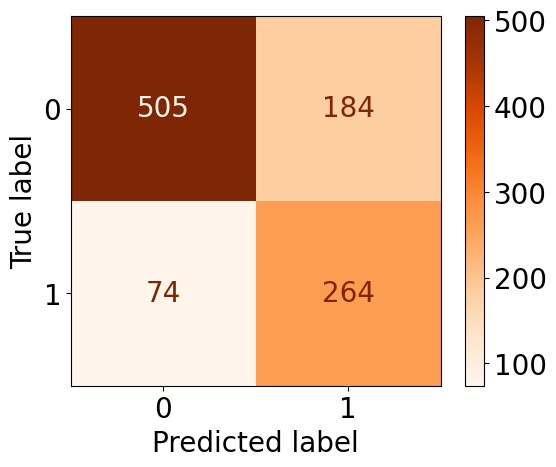

Accuracy: 0.7487828627069133
Precision: 0.7307395756229953
Recall: 0.7570056938707157
F1: 0.7341428468225493
AUC-ROC: 0.824
model_meta & 0.73 & 0.75 & 0.73 & 0.76 & 0.82 \\


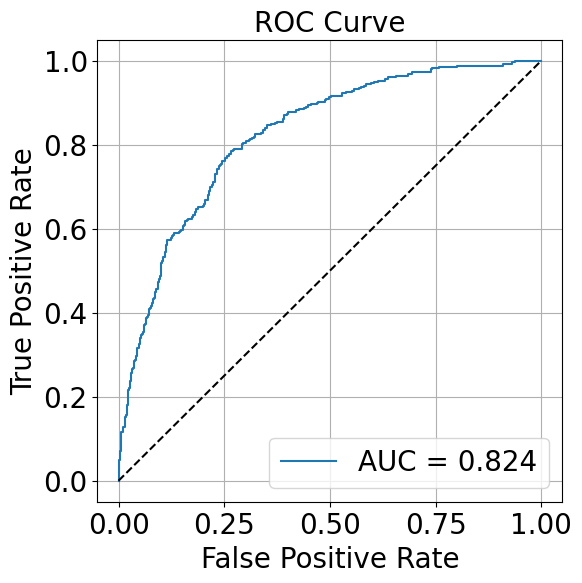

Best F1: 0.672 at threshold 0.50


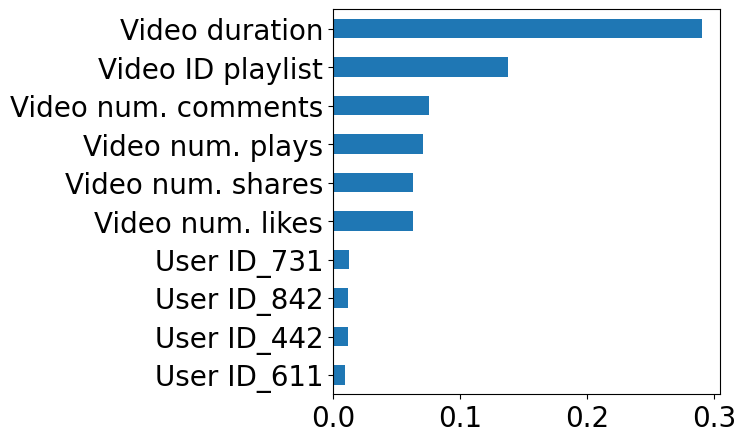

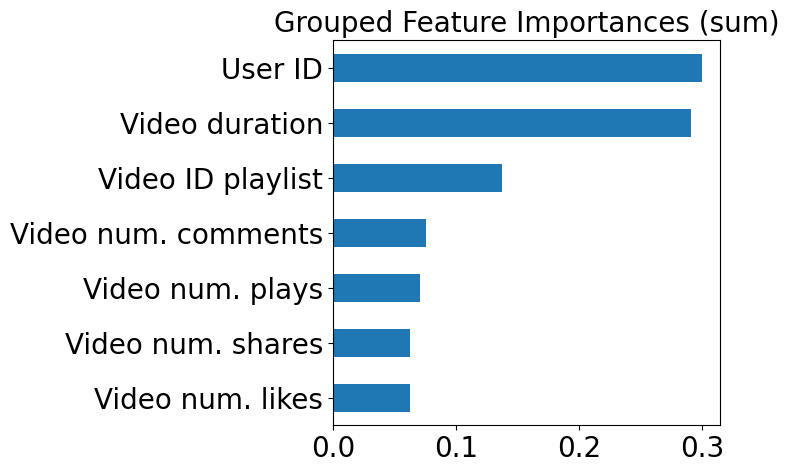

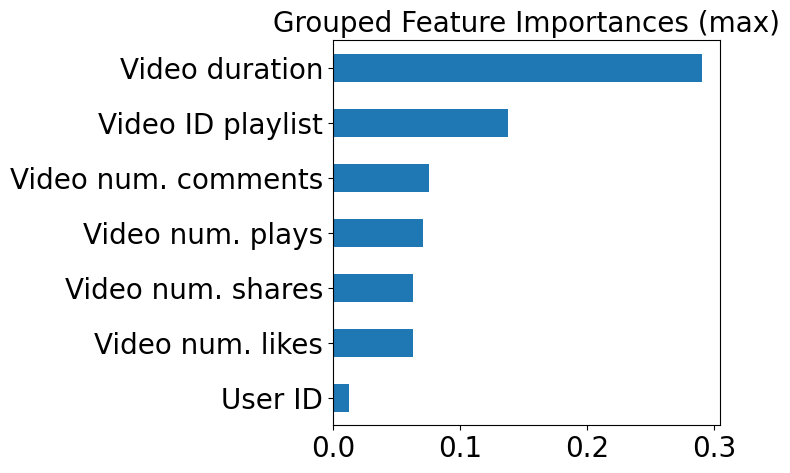

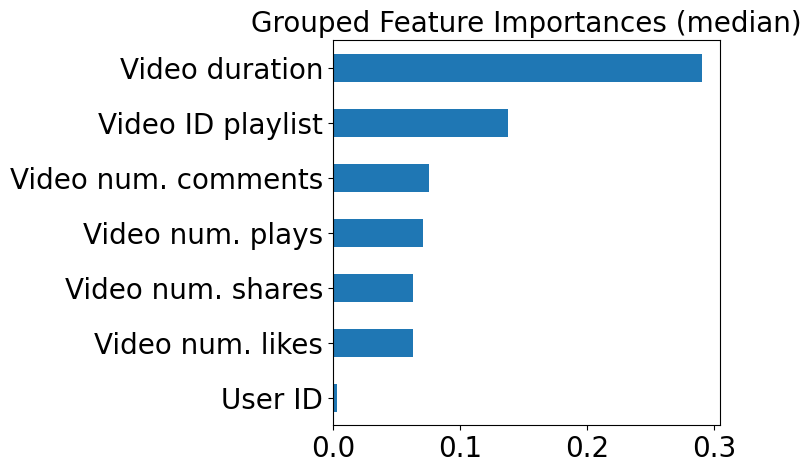

In [42]:
set_dim_fig((20,20,20))
rand_search_meta = randomforest_tiktok(X2_train_meta, X2_test_meta, y2_train_meta, y2_test_meta, note="model_meta")
#rand_search_meta = randomforest_tiktok(X2_train_meta, X2_test_meta, y2_train_meta, y2_test_meta, shap_set="train", note="model_meta")
#rand_search_meta = randomforest_tiktok(X2_train_meta, X2_test_meta, y2_train_meta, y2_test_meta, shap_set="test", note="model_meta")

## Model demographics

In [43]:
columns_dem = [c for c in columns_rf if c not in columns_meta] + ["Video ID playlist"]

In [44]:
X2_dem = df_all_rf[columns_dem]
y2_dem = df_all_rf["watched_until_end"]

In [45]:
# Split the data into training and test sets
X2_train_dem, X2_test_dem, y2_train_dem, y2_test_dem = train_test_split(X2_dem, y2_dem, test_size=0.2, random_state=42)

Train size: (4108, 161)
Test size: (1027, 161)


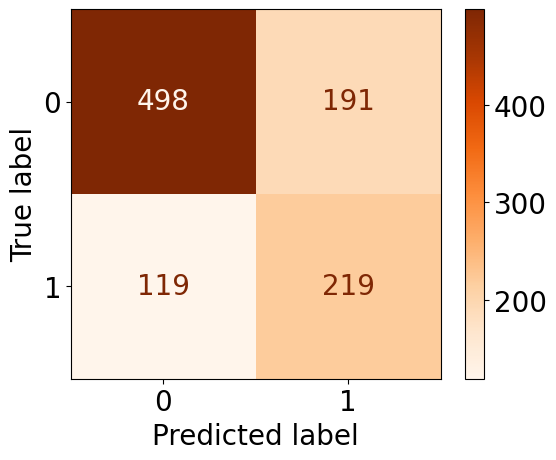

Accuracy: 0.6981499513145083
Precision: 0.6706388109261968
Recall: 0.6853578206988947
F1: 0.674097747131708
AUC-ROC: 0.748
model_dem & 0.67 & 0.70 & 0.67 & 0.69 & 0.75 \\


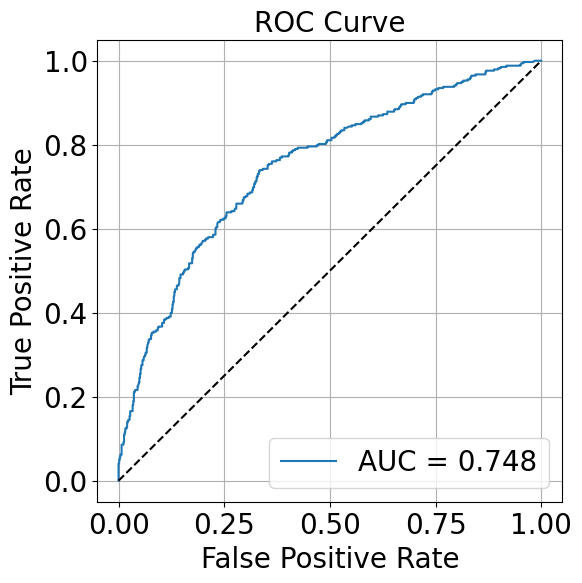

Best F1: 0.610 at threshold 0.45


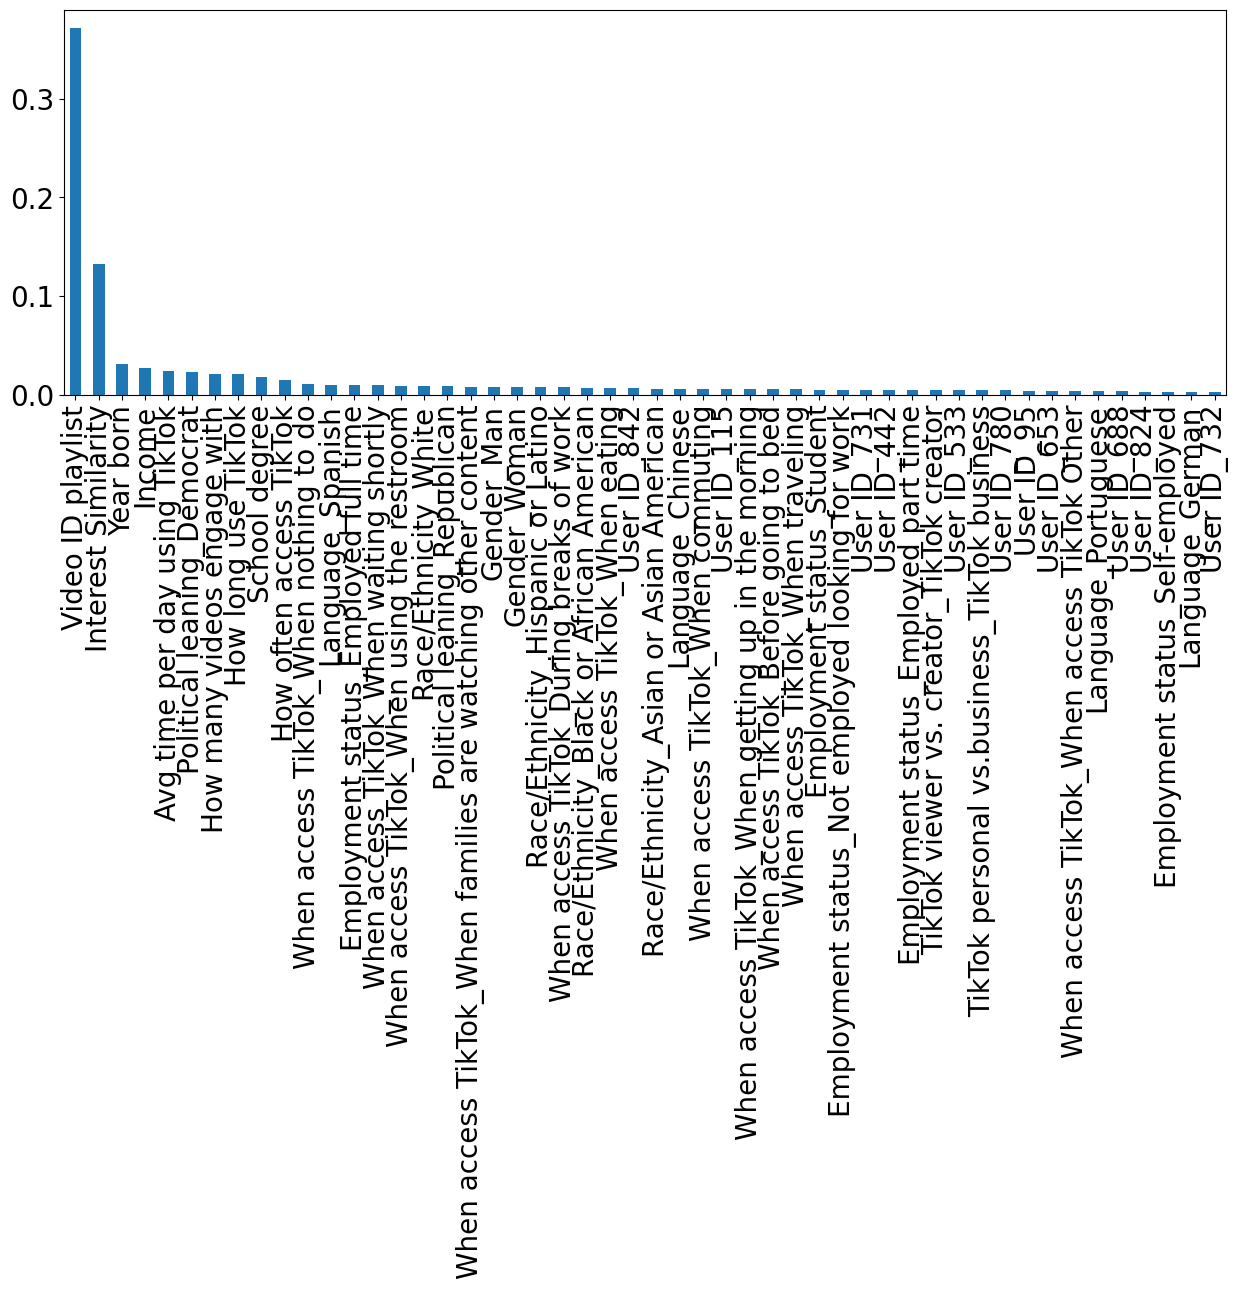

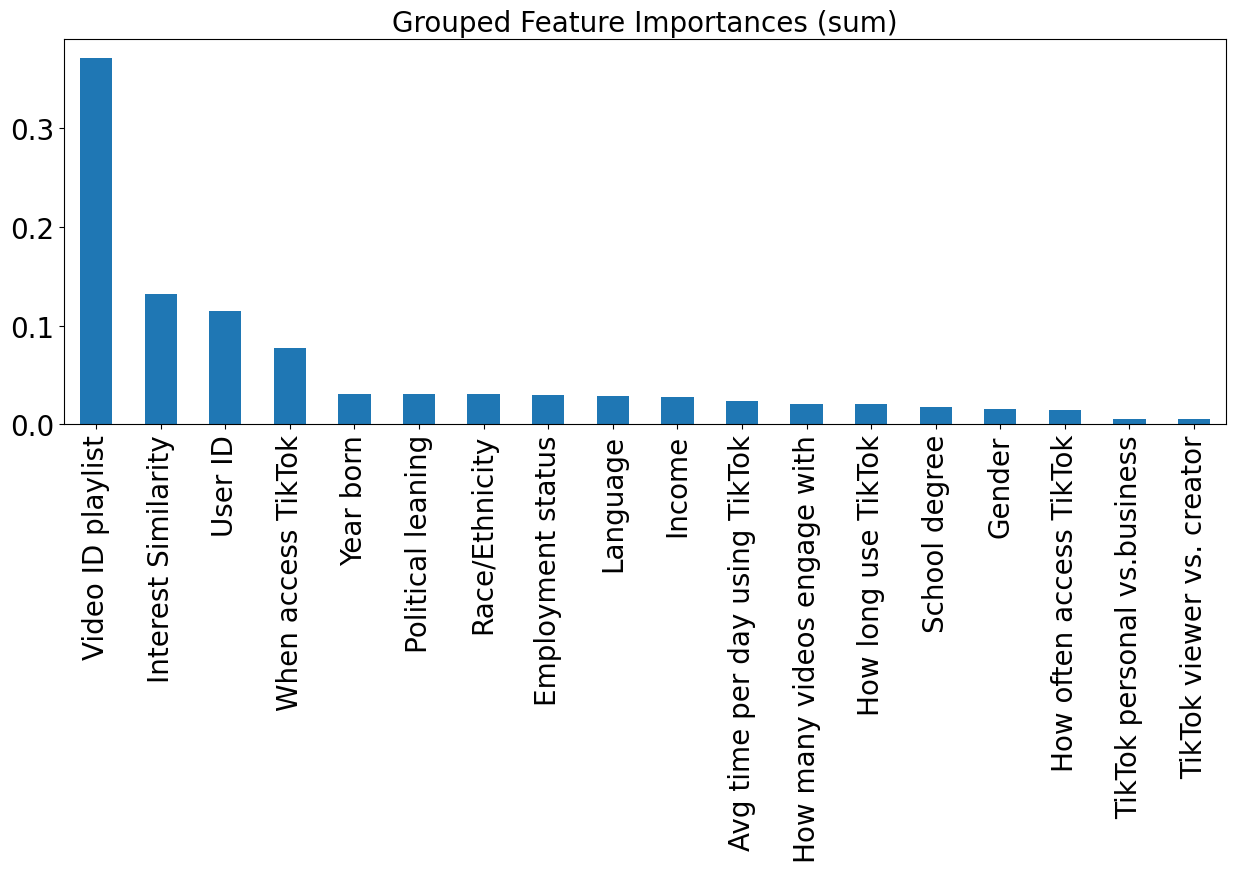

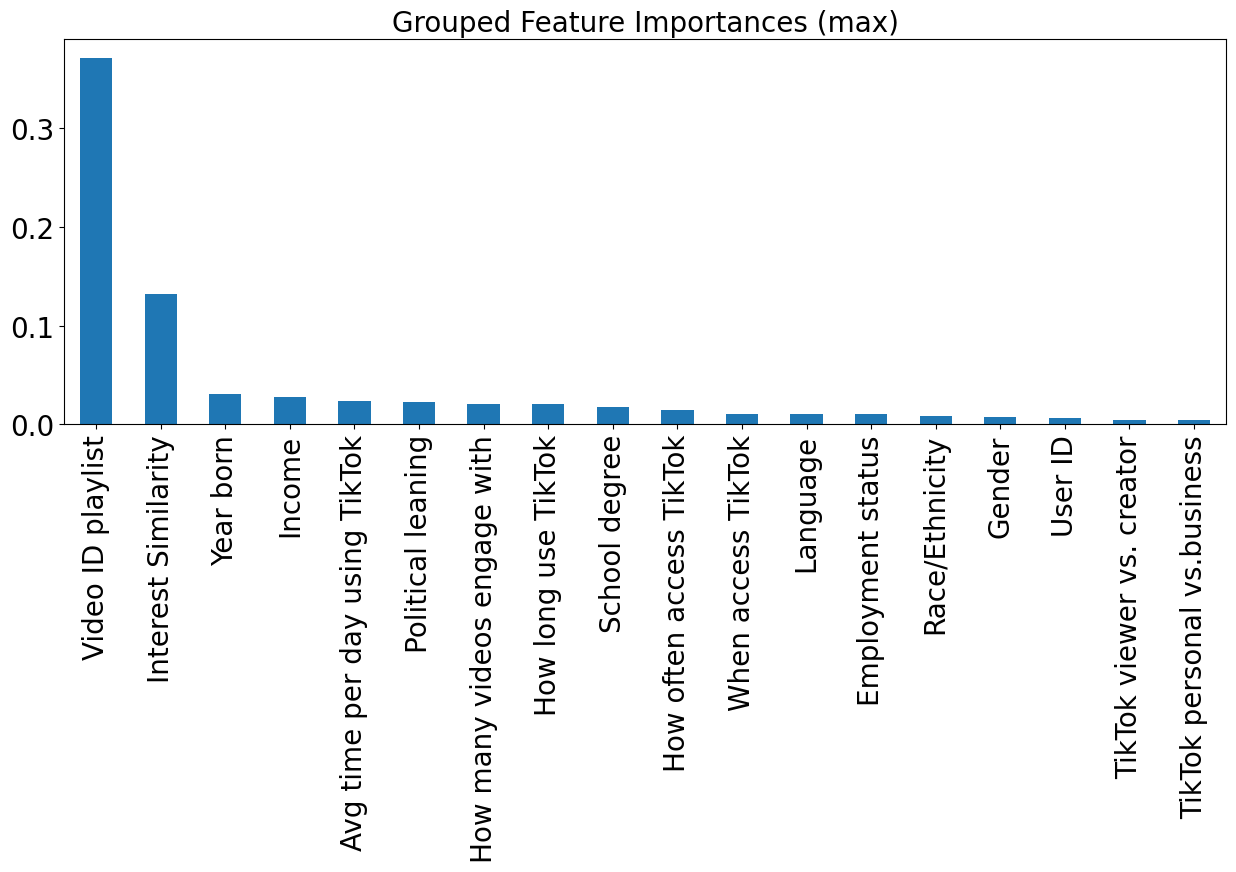

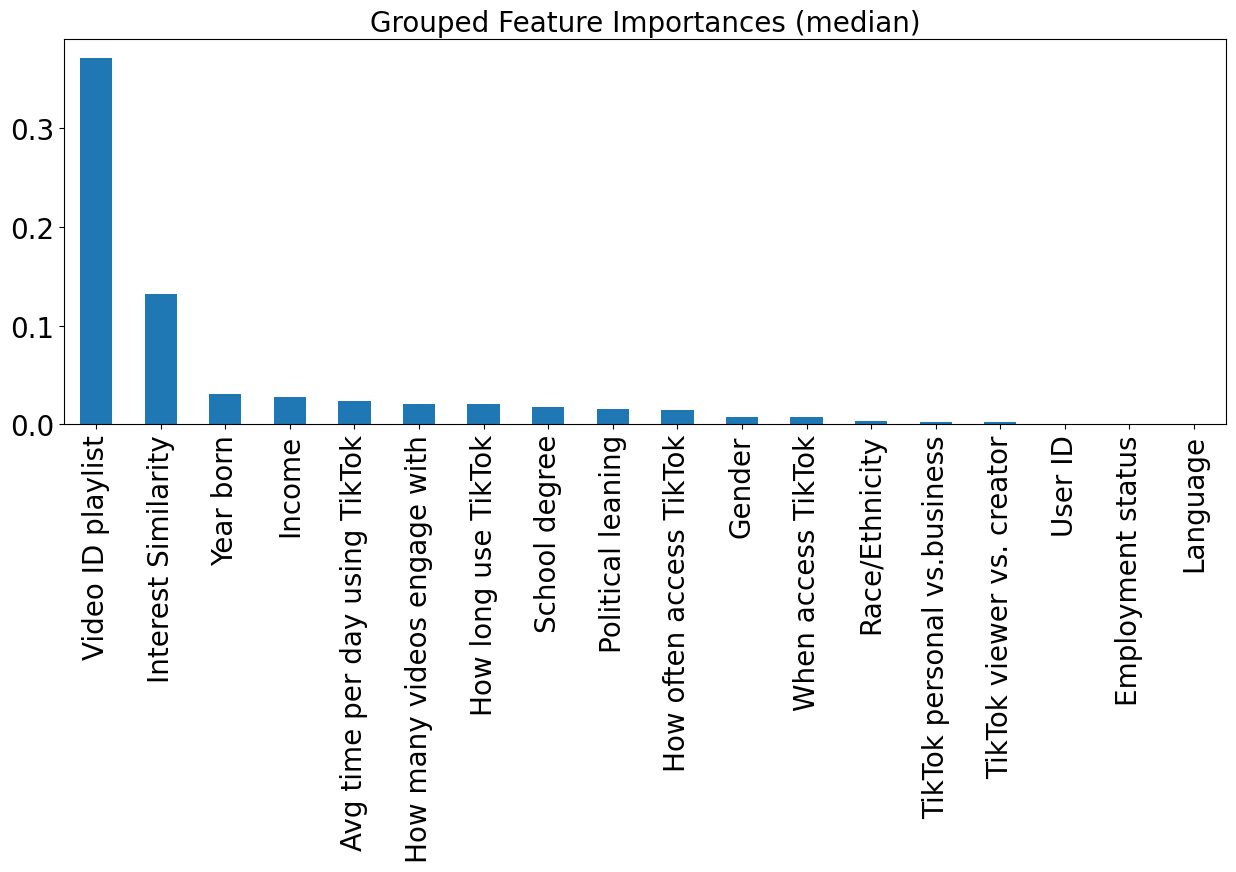

In [46]:
set_dim_fig((20,20,20))
rand_search_dem = randomforest_tiktok(X2_train_dem, X2_test_dem, y2_train_dem, y2_test_dem, note="model_dem")
#rand_search_dem = randomforest_tiktok(X2_train_dem, X2_test_dem, y2_train_dem, y2_test_dem, shap_set="train", note="model_dem")
#rand_search_dem = randomforest_tiktok(X2_train_dem, X2_test_dem, y2_train_dem, y2_test_dem, shap_set="test", note="model_dem")

# TikTok real world data

In [47]:
df_real_world = pd.read_csv("data/data_donation_for_classification_allvideosNorthCentral America.csv", index_col=0)
df_real_world

,email_md5,watched_until_end,percentage_watched,watched_6s+,liked,video_id_playlist,video_duration,video_share_count,video_play_count,video_comment_count,video_digg_count
12,af225c460d5c2574c30c1233e040437c,0,15.0,0,0,2217,13.0,237200.0,47500000.0,22900.0,2200000
13,af225c460d5c2574c30c1233e040437c,0,46.0,1,0,2219,13.0,237200.0,47500000.0,22900.0,2200000
15,b0a136d836a3dc742bd514ac3c6f4b92,0,23.0,0,0,0,13.0,237200.0,47500000.0,22900.0,2200000
16,37fe1f2671505d68d1b0f8840dd8647d,0,92.0,1,0,21605,13.0,237200.0,47500000.0,22900.0,2200000
25,a670f905b78ce21ec5ae78fb1e514d88,0,38.0,0,0,68,13.0,237200.0,47500000.0,22900.0,2200000
...,...,...,...,...,...,...,...,...,...,...,...
7934905,60d2994860f1d12b76f594e3543e6e71,1,117.0,1,0,193717,6.0,1269.0,2000000.0,1483.0,282600
7934906,60d2994860f1d12b76f594e3543e6e71,0,17.0,0,0,193718,6.0,535.0,498400.0,250.0,71200
7934907,60d2994860f1d12b76f594e3543e6e71,1,117.0,1,0,193719,6.0,398.0,860400.0,406.0,48600
7934908,60d2994860f1d12b76f594e3543e6e71,1,320.0,1,1,193720,5.0,2.0,10100.0,17.0,591


## Selecting only the first K videos watched by each user

In [48]:
K=104
df_real_world = df_real_world[df_real_world["video_id_playlist"] <= K]
df_real_world.reset_index(inplace=True, drop=True)

In [49]:
# One-hot encode the SEQUENTIAL_ID column
one_hot_user_real_df = pd.get_dummies(df_real_world['email_md5'], prefix='User ID')

df_real_world = df_real_world.drop(columns=['percentage_watched', 'liked', 'watched_6s+'])

df_real_world.rename(columns={'video_id_playlist': "Video ID playlist", 
                              'video_duration': "Video duration",
                              'video_digg_count': "Video num. likes",
                              'video_share_count': "Video num. shares",
                              'video_comment_count': "Video num. comments",
                              'video_play_count': "Video num. plays"}, inplace=True)			

In [50]:
df_real_world = df_real_world[columns_meta + ["watched_until_end"]]
df_real_world = df_real_world.merge(one_hot_user_real_df, left_index=True, right_index=True) # adding one hot encoding user ID"

In [51]:
X2_real_world_meta = df_real_world.drop(columns=['watched_until_end'])
y2_real_world = df_real_world["watched_until_end"]

In [52]:
print(X2_real_world_meta.shape, X2_real_world_meta.drop_duplicates().shape)

(9001, 114) (9001, 114)


In [53]:
# Split the data into training and test sets
X2_train_real_world_meta, X2_test_real_world_meta, y2_train_real_world, y2_test_real_world = train_test_split(X2_real_world_meta, y2_real_world, test_size=0.2, random_state=42)

Train size: (7200, 114)
Test size: (1801, 114)


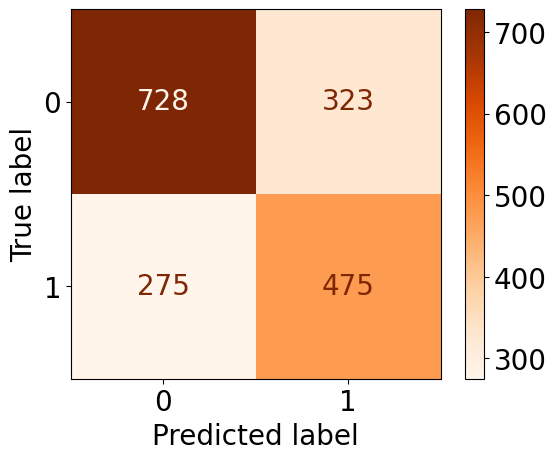

Accuracy: 0.6679622431982232
Precision: 0.6605303138204435
Recall: 0.6630034887408817
F1: 0.6612779249664738
AUC-ROC: 0.713
model_real_world_meta & 0.66 & 0.67 & 0.66 & 0.66 & 0.71 \\


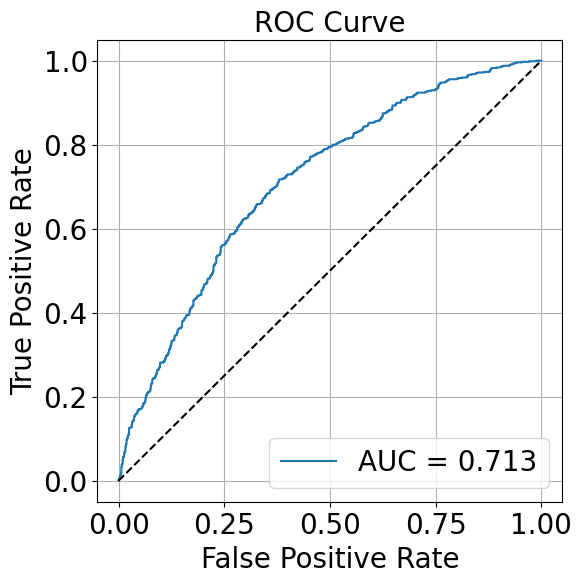

Best F1: 0.639 at threshold 0.44


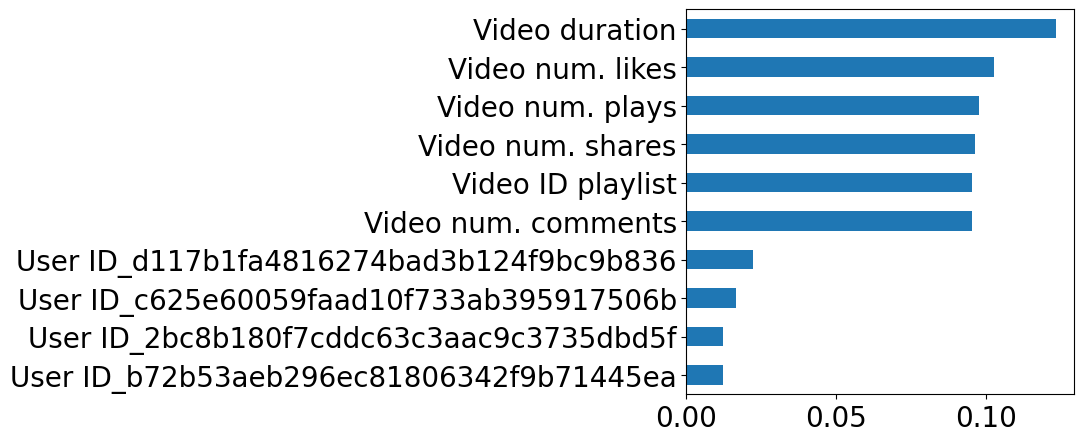

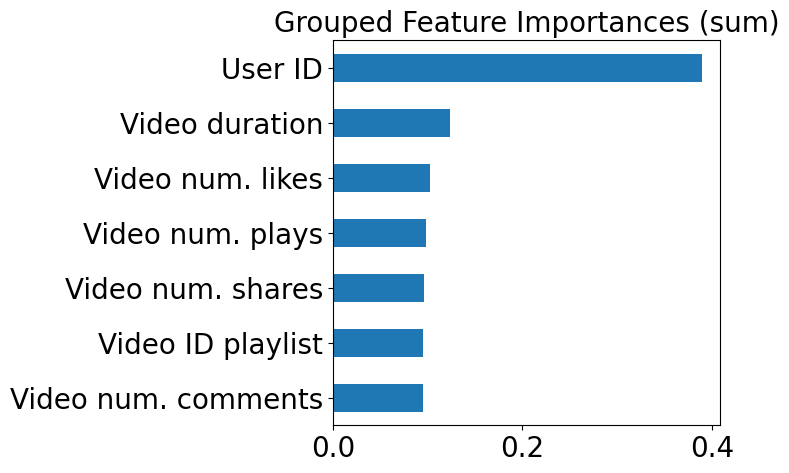

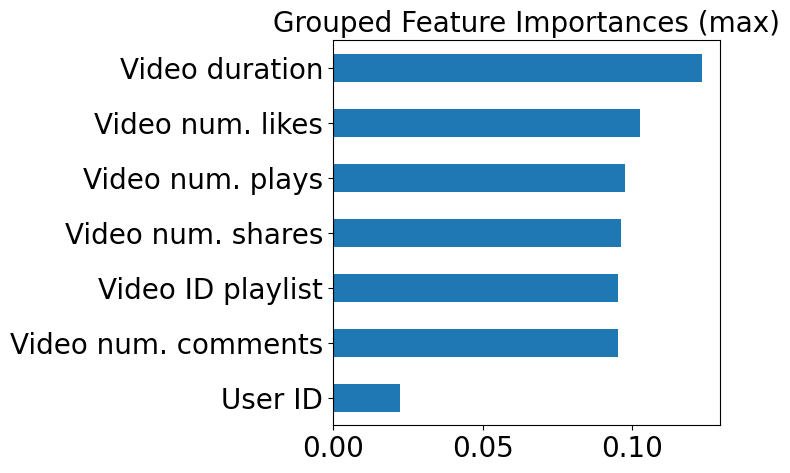

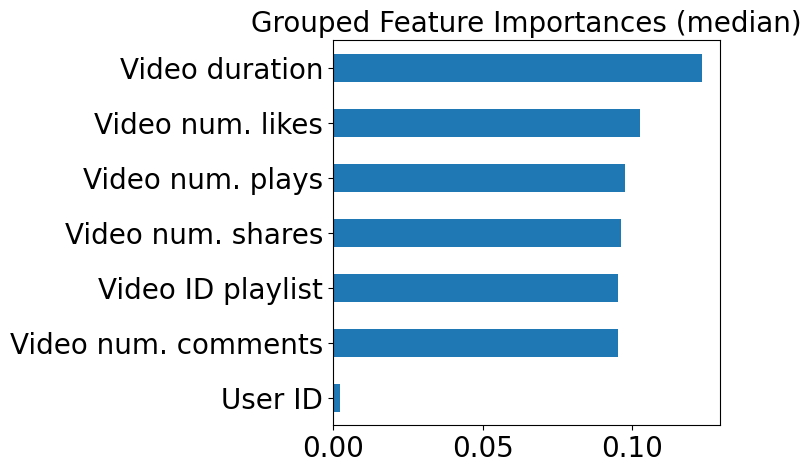

In [54]:
set_dim_fig((20,20,20))
rand_search_real_world_meta = randomforest_tiktok(X2_train_real_world_meta, X2_test_real_world_meta, y2_train_real_world, y2_test_real_world, note="model_real_world_meta")
#rand_search_real_world_meta = randomforest_tiktok(X2_train_real_world_meta, X2_test_real_world_meta, y2_train_real_world, y2_test_real_world, shap_set="train", note="model_real_world_meta")
#rand_search_real_world_meta = randomforest_tiktok(X2_train_real_world_meta, X2_test_real_world_meta, y2_train_real_world, y2_test_real_world, shap_set="test", note="model_real_world_meta")

# Summary Data for Classification: Real World vs. Experiment

In [55]:
print("******** Real World Data ********")
print("Users: 108 \nVideos: 6091")
print("Classification matrix:", X2_real_world_meta.shape)
print(y2_real_world.value_counts(), y2_real_world.value_counts(normalize=True))

******** Real World Data ********
Users: 108 
Videos: 6091
Classification matrix: (9001, 114)
watched_until_end
0    5102
1    3899
Name: count, dtype: int64 watched_until_end
0    0.566826
1    0.433174
Name: proportion, dtype: float64


In [56]:
print("******** Experiment data ********")
print("Users: 80 \nVideos: 105")
print("Classification matrix (all features):", X2_all.shape)
print("Classification matrix (video metadata):", X2_meta.shape)
print(y2_meta.value_counts(), y2_meta.value_counts(normalize=True))

******** Experiment data ********
Users: 80 
Videos: 105
Classification matrix (all features): (5135, 166)
Classification matrix (video metadata): (5135, 86)
watched_until_end
0    3468
1    1667
Name: count, dtype: int64 watched_until_end
0    0.675365
1    0.324635
Name: proportion, dtype: float64


In [57]:
df_all_rf[["Video ID playlist", "watched_until_end", "Video duration"]].groupby(by=["Video ID playlist", "watched_until_end"]).count()

Video duration
Video ID playlist watched_until_end                
0                 0                              31
                  1                              49
1                 0                              35
                  1                              45
2                 0                              76
...                                             ...
102               1                               1
103               0                              10
                  1                               6
104               0                              11
                  1                               5

[196 rows x 1 columns]